In [1]:
# load json from file
import json
import pickle
import random
import math
import numpy as np

def loadGame(game):
    with open('./games/'+game+'.json') as f:
        data = json.load(f)
    return data

# with open('./games/tripple.json') as f:
#     data = json.load(f)
# # print the data
# print(data)

games = [
    # loadGame('balloon'),
    # loadGame('riskavoidance'),
    loadGame('double1'),
    loadGame('tripple1'),
    # loadGame('tripple2'),
    loadGame('tripple3'),
    loadGame('tripple4'),
]



In [2]:
alpha = 0.1

class Node:
  def __init__(self, node, nodes):
    self.id = pickle.dumps(node)
    self.rewardHistory = []
    self.Vc = 0
    if 'rewards' in node:
      self.rewards = node['rewards']
    if 'actions' not in node:
      self.isLeaf = True
      return
    self.isLeaf = False
    if 'up' in node['actions']:
      self.up = getNode(node['actions']['up'][0]['next'], nodes)
    if 'down' in node['actions']:
      self.down = getNode(node['actions']['down'][0]['next'], nodes)
    if 'left' in node['actions']:
      self.left = getNode(node['actions']['left'][0]['next'], nodes)
    if 'right' in node['actions']:
      self.right = getNode(node['actions']['right'][0]['next'], nodes)

  def __str__(self):
    if self.isLeaf:
      return 'Leaf'
    return 'Node'
  
  def getReward(self):
    # get random number
    r = random.random()
    # sample reward
    s = 0
    if not hasattr(self, 'rewards'):
      return 0
    for i in range(len(self.rewards)):
      s += self.rewards[i]['p']
      if r < s:
        reward = self.rewards[i]['value']
        self.rewardHistory.append(reward)
        self.Vc = self.Vc + alpha * (reward - self.Vc)
        return reward
      
  def getAverageReward(self):
    return sum(self.rewardHistory) / len(self.rewardHistory) if len(self.rewardHistory) > 0 else 0
#    return self.Vc

def getNode(node, nodes):
  # return node in nodes with matching id
  for n in nodes:
    if n.id == pickle.dumps(node):
      return n
  node = Node(node, nodes)
  nodes.append(node)
  return node


In [3]:
class Path:
  def __init__(self, path):
    self.path = path
    self.length = len(path)
    self.taken = 0

  def getReward(self):
    reward = 0
    for node in self.path:
        reward += node.getReward()
    return reward

def getPaths(node, path):
  if node.isLeaf:
    return [Path(path + [node])]
  paths = []
  if hasattr(node, 'left'):
    paths += getPaths(node.left, path + [node])
  if hasattr(node, 'up'):
    paths += getPaths(node.up, path + [node])
  if hasattr(node, 'down'):
    paths += getPaths(node.down, path + [node])
  if hasattr(node, 'right'):
    paths += getPaths(node.right, path + [node])
  return paths

In [4]:
def selectBestPath(paths):
  # select path with highest average reward
  rewards = []
  for path in paths:
    reward = 0
    for node in path.path:
      reward += node.getAverageReward()
    rewards.append(reward)
  # get max from rewards
  bestPath = max(range(len(rewards)), key=rewards.__getitem__)
  return paths[bestPath]

def epsilonGreedy(selectBestPath, epsilon):
  def selectPath(paths):
    # select path with highest average reward
    if random.random() < epsilon:
      return random.choice(paths)
    return selectBestPath(paths)
  return selectPath


In [5]:
def runGame(game, selectPathFunc, warmup=True, warmups=1):
  nodes = []
  start = Node(game['start'], nodes)
  paths = getPaths(start, [])

  score = 0
  for i in range(75):
      if warmup and i < len(paths) * warmups:
        path = paths[i % len(paths)]
      else:
        selectPath = selectPathFunc(i)
        # shuffle paths
        random.shuffle(paths)
        # select path
        path = selectPath(paths)
        path.taken += 1
      # traverse path to update reward
      reward = 0
      for node in path.path:
          reward += node.getReward()
      score += reward

  return score


In [9]:
# calculate expected best path reward

atRandom = []

for game in games:
    nodes = []
    start = Node(game['start'], nodes)
    paths = getPaths(start, [])

    for i in range(100000):
        for path in paths:
            path.history = [] if not hasattr(path, 'history') else path.history
            path.history.append(path.getReward())

    expectedPathReward = [sum(path.history)/len(path.history) for path in paths]
    pathRewardVariances = [np.var(path.history) for path in paths]

    expectedPathReward, pathRewardVariances
    game['expectedBest'] = 75 * max(expectedPathReward)
    atRandom.append((sum(expectedPathReward) / len(expectedPathReward)) / max(expectedPathReward))
    print(expectedPathReward)
    print(pathRewardVariances)
    print((sum(expectedPathReward) / len(expectedPathReward)) / max(expectedPathReward))

[game['expectedBest'] for game in games]

[-0.50802, 1.99474, 1.50461]
[3.2607956795999997, 0.6652123323999999, 3.9034387478999992]
0.4998696571984319
[1.0, 2.0, 3.0]
[0.0, 0.0, 0.0]
0.6666666666666666
[1.99928, 1.50175, 1.00077]
[1.5070394816, 0.9149369375, 2.0007694071]
0.7505702052738987
[2.99664, 2.00072, 2.50326, 1.5007, 1.99514, 1.49379]
[3.4957287104, 1.4982994815999997, 1.7435093723999997, 0.91643951, 1.1653563804000004, 2.2484614359]
0.6946808202965098


[149.6055, 225.0, 149.946, 224.74800000000002]

In [46]:
atRandom

[0.4998696571984319,
 0.6666666666666666,
 0.7505702052738987,
 0.6946808202965098]

In [10]:
results = [atRandom]


# Epsilon greedy

Game 0
Max score: 0.9880652783487237 at epsilon: 0.0
Game 1
Max score: 0.8893777777777778 at epsilon: 0.22
Game 2
Max score: 0.9029917436943967 at epsilon: 0.16
Game 3
Max score: 0.8513980102158861 at epsilon: 0.26
Average max score: 0.8807498850209106 at epsilon: 0.12


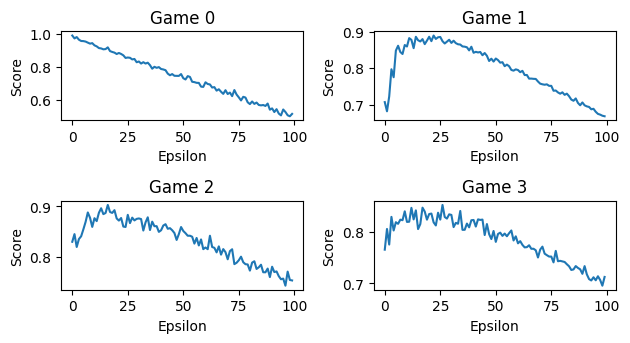

In [61]:
epsilonSteps = 1
alpha = 0.999
def runEpsilonGreedySimulation(game):
    epsilonScores = []
    stds = []
    for epsilon in range(0, 100, epsilonSteps):
        scores = []
        for i in range(100):
            score = runGame(game, lambda x:epsilonGreedy(selectBestPath, epsilon/100.), False)
            scores.append(score)

        avgScore = sum(scores) / len(scores)
        # print(str(epsilon) + ' Score: ' + str(avgScore))
        std = np.std(scores)
        epsilonScores.append(avgScore)
        stds.append(std)
    return (epsilonScores, stds)

allScores = []
allStds = []
import matplotlib.pyplot as plt
# run simulation and plot in a grid
for i in range(0,len(games)):
    print('Game ' + str(i))
    (scores, stds) = runEpsilonGreedySimulation(games[i])
    epsilonScores = [x/games[i]['expectedBest'] for x in scores]
    # get max score index
    maxScoreIndex = epsilonScores.index(max(epsilonScores))
    allScores.append(epsilonScores)
    allStds.append([std / games[i]['expectedBest'] for std in stds])
    # print max score
    print('Max score: ' + str(epsilonScores[maxScoreIndex]) + ' at epsilon: ' + str(maxScoreIndex*epsilonSteps/100.0))
    plt.subplot(3, 2, i+1)
    # add margin between plots
    plt.subplots_adjust(hspace=0.5)
    plt.title('Game ' + str(i))
    plt.plot(range(0, 100, epsilonSteps), epsilonScores)
    plt.xlabel('Epsilon')
    plt.ylabel('Score')
    # tight fit
    plt.tight_layout()

avgMaxScores = [sum([allScores[j][i] for j in range(len(games))]) / len(games) for i in range(len(allScores[0]))]
# argmax of avgMaxScores
maxScoreIndex = avgMaxScores.index(max(avgMaxScores))
print(f'Average max score: {max(avgMaxScores)} at epsilon: {maxScoreIndex*epsilonSteps/100.0}')

results.append([allScores[i][maxScoreIndex] for i in range(len(games))])
greedyStds = [allStds[i][maxScoreIndex] for i in range(len(games))]


# Epsilon First

Game 0
Max score: 0.9936132027231619 at i: 1
Game 1
Max score: 0.9550666666666666 at i: 9
Game 2
Max score: 0.9217985141317541 at i: 17
Game 3
Max score: 0.8885062380977805 at i: 11
Average max score: 0.9209338131036298 at epsilon: 0.08


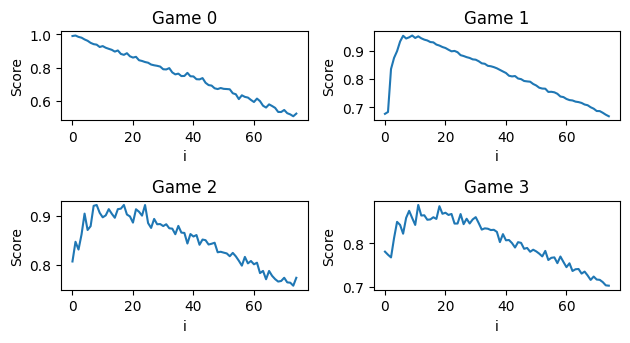

In [66]:
alpha = 0.999

def runEpsilonFirstSimulation(game):
    epsilonScores = []
    stds = []
    for epsilon in range(0, 75, 1):
        scores = []
        for i in range(100):
            score = runGame(game, lambda x:epsilonGreedy(selectBestPath, 1 if x<epsilon else 0), False)
            scores.append(score)

        avgScore = sum(scores) / len(scores)
        # print(str(epsilon) + ' Score: ' + str(avgScore))
        # std
        std = np.std(scores)
        epsilonScores.append(avgScore)
        stds.append(std)
    return (epsilonScores, stds)

allScores = []
allStds = []
import matplotlib.pyplot as plt
# run simulation and plot in a grid
for i in range(0,len(games)):
    print('Game ' + str(i))
    (scores, stds) = runEpsilonFirstSimulation(games[i])
    epsilonScores = [x/games[i]['expectedBest'] for x in scores]
    # get max score index
    maxScoreIndex = epsilonScores.index(max(epsilonScores))
    allScores.append(epsilonScores)
    allStds.append([std / games[i]['expectedBest'] for std in stds])
    # print max score
    print('Max score: ' + str(epsilonScores[maxScoreIndex]) + ' at i: ' + str(maxScoreIndex))
    plt.subplot(3, 2, i+1)
    # add margin between plots
    plt.subplots_adjust(hspace=0.5)
    plt.title('Game ' + str(i))
    plt.plot(range(0, 75, 1), epsilonScores)
    plt.xlabel('i')
    plt.ylabel('Score')
    # tight fit
    plt.tight_layout()

avgMaxScores = [sum([allScores[j][i] for j in range(len(games))]) / len(games) for i in range(len(allScores[0]))]
# argmax of avgMaxScores
maxScoreIndex = avgMaxScores.index(max(avgMaxScores))
print(f'Average max score: {max(avgMaxScores)} at epsilon: {maxScoreIndex*epsilonSteps/100.0}')

results.append([allScores[i][maxScoreIndex] for i in range(len(games))])
epsilonFirstStds = [allStds[i][maxScoreIndex] for i in range(len(games))]


# Epsilon Niklas

Game 0
Max score: 1.334777130519934 at i: 11
Game 1
Max score: 0.8875111111111111 at i: 11
Game 2
Max score: 1.3317460952609605 at i: 11
Game 3
Max score: 0.8885062380977805 at i: 11
Average max score: 1.1106351437474464 at epsilon: 0.11


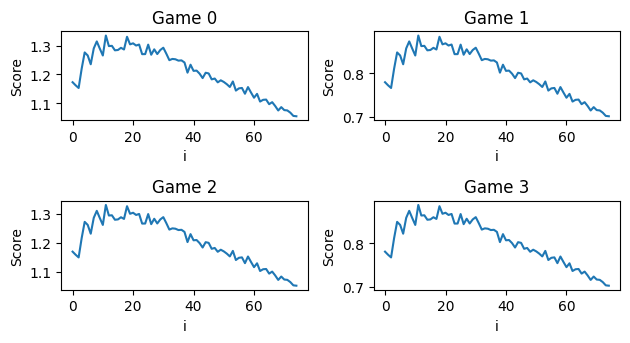

In [69]:
# epislon niklas
alpha = 0.999

def runEpsilonNiklasSimulation(game):
    epsilonScores = []
    stds = []
    for epsilon in range(0, 75, 1):
        scores = []
        for i in range(100):
            score = runGame(game, lambda x:epsilonGreedy(selectBestPath, 0), True, epsilon)
            scores.append(score)

        avgScore = sum(scores) / len(scores)
        # print(str(epsilon) + ' Score: ' + str(avgScore))
        #std
        std = np.std(scores)
        epsilonScores.append(avgScore)
        stds.append(std)
    return (epsilonScores, stds)

allScores = []
allStds = []
import matplotlib.pyplot as plt
# run simulation and plot in a grid
for i in range(0,len(games)):
    print('Game ' + str(i))
    (score, stds) = runEpsilonNiklasSimulation(games[i])
    epsilonScores = [x/games[i]['expectedBest'] for x in scores]
    # get max score index
    maxScoreIndex = epsilonScores.index(max(epsilonScores))
    allScores.append(epsilonScores)
    allStds.append([std / games[i]['expectedBest'] for std in stds])
    # print max score
    print('Max score: ' + str(epsilonScores[maxScoreIndex]) + ' at i: ' + str(maxScoreIndex))
    plt.subplot(3, 2, i+1)
    # add margin between plots
    plt.subplots_adjust(hspace=0.5)
    plt.title('Game ' + str(i))
    plt.plot(range(0, 75, 1), epsilonScores)
    plt.xlabel('i')
    plt.ylabel('Score')
    # tight fit
    plt.tight_layout()

avgMaxScores = [sum([allScores[j][i] for j in range(len(games))]) / len(games) for i in range(len(allScores[0]))]
# argmax of avgMaxScores
maxScoreIndex = avgMaxScores.index(max(avgMaxScores))
print(f'Average max score: {max(avgMaxScores)} at epsilon: {maxScoreIndex*epsilonSteps/100.0}')

results.append([allScores[i][maxScoreIndex] for i in range(len(games))])
niklasStds = [allStds[i][maxScoreIndex] for i in range(len(games))]


# Softmax


In [57]:
beta = 20

def softmaxSelect(i):
    def selectPath(paths):
        # select path with highest average reward
        rewards = []
        for path in paths:
            reward = 0
            for node in path.path:
                reward += node.getAverageReward()
            rewards.append(reward * beta)

        soft = np.exp(rewards) / np.sum(np.exp(rewards))
        bestPath = np.random.choice(range(len(paths)), p=soft)
        return paths[bestPath]
    return selectPath

def runSoftmaxSimulation(game):
    scores = []
    for i in range(100):
        score = runGame(game, softmaxSelect)
        scores.append(score)

    avgScore = sum(scores) / len(scores)
    # std
    std = np.std(scores)
    return (avgScore, std)

# run simulation and plot in a grid
scores = []
stds = []
for i in range(0,len(games)):
    print('Game ' + str(i))
    (score, std) = runSoftmaxSimulation(games[i])
    scores.append(score / games[i]['expectedBest'])
    stds.append(std / games[i]['expectedBest'])
    print('Score: ' + str(score))

print('Average score for all games: ' + str(np.average(scores)))

results.append(scores)
softmaxStds = stds



Game 0
Score: 146.14
Game 1
Score: 222.0
Game 2
Score: 129.84
Game 3
Score: 195.34
Average score for all games: 0.9246413416790442


# UCB

In [49]:
def ucb1(i):
    def selectPath(paths):
        # select path with highest average reward
        rewards = []
        for path in paths:
            reward = 0
            for node in path.path:
                reward += node.getAverageReward()
            rewards.append(reward)
        highestAverageReward = max(1, max(rewards))
        for i, (reward, path) in enumerate(zip(rewards, paths)):
            # pathVisits = path.taken + 1
            # pathVisits = sum([len(p.rewardHistory) for p in path.path])/len(path.path)
            pathVisits = max([len(p.rewardHistory) for p in path.path]) + 1
            experienceFactor = math.sqrt(2 * math.log(i+1)/pathVisits)
            rewards[i] = reward/highestAverageReward + experienceFactor

        # rewards = [rewards[i]/highestAverageReward + math.sqrt(2*math.log(i+1)/(paths[i].taken if paths[i].taken > 0 else 1)) for i in range(len(rewards))]
        # get max from rewards
        bestPath = max(range(len(rewards)), key=rewards.__getitem__)
        return paths[bestPath]
    return selectPath

def runUCB1Simulation(game):
    scores = []
    for i in range(100):
        score = runGame(game, ucb1)
        scores.append(score)

    avgScore = sum(scores) / len(scores)
    # std
    std = np.std(scores)
    return (avgScore, std)



In [58]:
alpha = 0.999

# run simulation and plot in a grid
scores = []
stds = []
for i in range(0,len(games)):
    print('Game ' + str(i))
    (score, std) = runUCB1Simulation(games[i])
    scores.append(score / games[i]['expectedBest'])
    stds.append(std / games[i]['expectedBest'])
    print('Score: ' + str(score / games[i]['expectedBest']))

print('Average score for all games: ' + str(np.average(scores)))
print(stds)

results.append(scores)

ucbStds = stds


Game 0
Score: 0.9533740403929
Game 1
Score: 0.9675111111111111
Game 2
Score: 0.9063262774598856
Game 3
Score: 0.8622546140566322
Average score for all games: 0.9223665107551322
[0.04587024712713889, 0.007892987980432963, 0.13003313599593277, 0.10932434258240752]


([<matplotlib.axis.XTick at 0x1276aa8e0>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

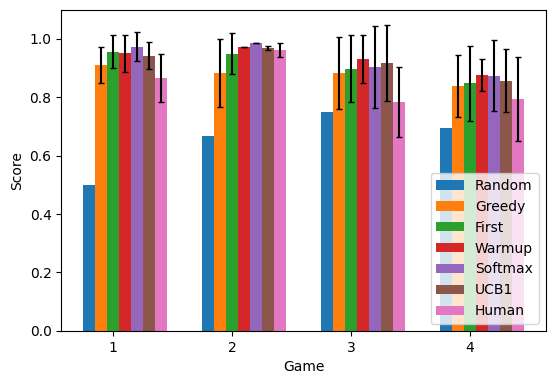

In [70]:
# plot results
import matplotlib.pyplot as plt
import numpy as np

# plot results as bar chart
# plt.figure(figsize=(10, 5))
plt.xlabel('Game')
plt.ylabel('Score')


# set width to 600
plt.gcf().set_size_inches(600/96, 400/96)

# plt.bar(['Greedy', 'First', 'Niklas', 'Softmax', 'UCB1'], [np.average(results[i]) for i in range(len(results))])
plt.bar(np.arange(4)-0.2, resultsWithHuman[0], width=0.1, capsize=2)
plt.bar(np.arange(4)-0.1, resultsWithHuman[1], yerr=greedyStds, width=0.1, capsize=2)
plt.bar(range(4), resultsWithHuman[2], yerr=epsilonFirstStds, width=0.1, capsize=2)
plt.bar(np.arange(4)+0.1, resultsWithHuman[3], yerr=niklasStds, width=0.1, capsize=2)
plt.bar(np.arange(4)+0.2, resultsWithHuman[4], yerr=softmaxStds, width=0.1, capsize=2)
plt.bar(np.arange(4)+0.3, resultsWithHuman[5], yerr=ucbStds, width=0.1, capsize=2)
plt.bar(np.arange(4)+0.4, resultsWithHuman[6], yerr=humanStds, width=0.1, capsize=2)

# add legend
plt.legend(['Random', 'Greedy', 'First', 'Warmup', 'Softmax', 'UCB1', 'Human'], loc='lower right')

# change x label to 1 to 5
plt.xticks(range(4), range(1,5))

- legends
- 1-5
- box plots
- human scores
- plot med total score


In [43]:
# newResults = results

# newResults.append([0.809137825048963,
# 0.9422222222222222,
# 1.0100048811786049,
# 0.7499656705855015,
# 0.7461224048258635])

# newResults

resultsWithHuman = results.copy()

resultsWithHuman.append([
0.8647720070716169,
0.9613888888888888,
0.7851289979869343,
0.7952094051433544
    ])

# newResults.append([0.5034410862022952, 0.6666666666666666, 0.9987730388626604, 0.7494212297430409, 0.6954060221517226])



(0.0, 1.0)

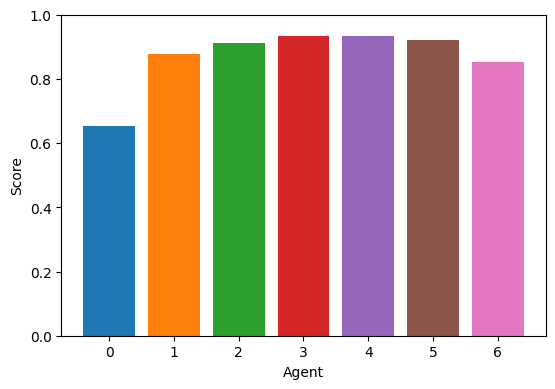

In [48]:
averageResult = [sum(resultsWithHuman[x])/4 for x in range(7)]

# plot averageResult with bars where each bar is a different color
plt.figure(figsize=(10, 5))
plt.xlabel('Agent')
plt.ylabel('Score')

# set width to 600
plt.gcf().set_size_inches(600/96, 400/96)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:7]
plt.bar(range(7), averageResult, color=colors)

# y-axis 0.5 to 1.1
plt.ylim(0.0, 1.0)



In [64]:
humanStds = [0.08207625203461805, 0.02371220189097838, 0.11975218666142484,0.14431889428548034]

In [94]:
# Do t-tests

agents = ['greedy', 'first', 'warmup', 'softmax', 'ucb1']
agentsMean = resultsWithHuman[1:6]
agentsStd = [greedyStds, epsilonFirstStds, niklasStds, softmaxStds, ucbStds]

humanMean = resultsWithHuman[6]
def ttest(agent, game):
    mean1 = agentsMean[agent][game]
    std1 = agentsStd[agent][game]
    var1 = std1**2

    mean2 = humanMean[game]
    std2 = humanStds[game]
    var2 = std2**2

    n1 = 100
    n2 = 15

    # T-test
    t = (mean1 - mean2) / math.sqrt(var1/(n1-1) + var2/(n2-1))
    return t

z = 1.984 # 95% confidence interval, two tail

tscores = []
for agent in range(5):
    print(f'Agent {agents[agent]}')
    tscores.append([])
    for game in range(4):
        t = ttest(agent, game)
        print(f'Game {game}:', t, 'significant' if abs(t) > z else 'not significant')
        tscores[agent].append(t)

# create table of tscores
import pandas as pd
df = pd.DataFrame(tscores, columns=['Game 1', 'Game 2', 'Game 3', 'Game 4'], index=agents)
df


Agent greedy
Game 0: 2.0107343126985593 significant
Game 1: -5.843128583171082 significant
Game 2: 2.889353230199985 significant
Game 3: 1.0911758028308751 not significant
Agent first
Game 0: 4.0167574849516825 significant
Game 1: -1.3168680989423323 not significant
Game 2: 3.327326425354239 significant
Game 3: 1.2754934694333837 not significant
Agent warmup
Game 0: 3.7838241735668183 significant
Game 1: 1.8847688203713604 not significant
Game 2: 4.417926720193583 significant
Game 3: 2.1159948479454687 significant
Agent softmax
Game 0: 4.784008563421428 significant
Game 1: 3.9886968059021615 significant
Game 2: 3.40600423906798 significant
Game 3: 1.9449722885492713 not significant
Agent ucb1
Game 0: 3.4488343027027852 significant
Game 1: 1.1047075521727494 not significant
Game 2: 3.8105981608576234 significant
Game 3: 1.5452534021234143 not significant


,Game 1,Game 2,Game 3,Game 4
greedy,2.010734,-5.843129,2.889353,1.091176
first,4.016757,-1.316868,3.327326,1.275493
warmup,3.783824,1.884769,4.417927,2.115995
softmax,4.784009,3.988697,3.406004,1.944972
ucb1,3.448834,1.104708,3.810598,1.545253
